In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using matplotlib directly to import and operate on images.

Writing a function to convert the image into grayscale just to compare with images after convolution output.
Also the grayscale conversion factors have been referred from Matplotlib's documentation. Other libraries might impliment this in a different way

In [2]:
img = mpimg.imread('smug_cat.jpg')

def rgb2gray(rgb):
    temp = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    temp = temp[..., np.newaxis]
    return temp

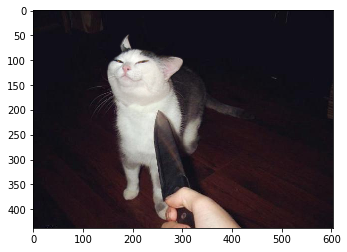

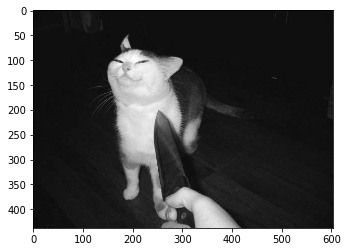

In [3]:
gray = rgb2gray(img)
gray = gray[:,:,0] #Outputs (a,b,1) so converting it to a 2d matrix for simplicity
plt.imshow(img)
plt.show()
plt.imshow(gray, cmap='gray')
plt.show()

Different activation functions. Here I've coded ReLU, Sigmoid and TanH activations

In [4]:
def sigmoid(x):
    temp = 1/(1+np.exp(-x))
    return temp

def relu(x):
    x[x<0]=0
    return x

def tanh(x):
    return np.tanh(x)

## Conv2D fucntion

This function takes following inputs (in the same order) :

1. Image/any 3D matrix as an input (Hence both grayscale and RGB images can be fed)
2. Kernel dimensions to be used. Can be rectangular as well. Depth of the kernel is automatically fixed according to the image/matrix fed
3. Stride
4. Padding - has two options - True or None. If true, after convolution, the image is as close to resolution as the input image albeit with a black border (aka 0s surrounding the matrix)
5. Activation - can be any of the activations mentioned earlier

In [5]:
def conv2D(inp, ker_dim, stride, padding, activation):
    h,w,d = np.shape(inp)
    ker_list = list(ker_dim)
    ker_list.append(d)
    ker_dim = tuple(ker_list)
    ker_val = np.random.uniform(0,1e-3,ker_dim)

    ini_w = 0
    ini_h = 0
    
    pad_w = (((stride-1)*w) + ker_list[1] - stride)/2
    pad_w = int(pad_w)
        
    pad_h = (((stride-1)*h) + ker_list[0] - stride)/2
    pad_h = int(pad_h)
    
    if padding == "True":
        pad_inp = np.zeros(((h+2*pad_h),(w+2*pad_w),d))
        for i in range(d):
            pad_inp[:,:,i] = np.pad(inp[:,:,i], ((pad_h,pad_h),(pad_w,pad_w)), 'constant')
        pad_inp = pad_inp.astype(int)
        out_w = int(((w + 2*pad_w - ker_list[1])/stride) + 1)
        out_h = int(((h + 2*pad_h - ker_list[0])/stride) + 1)
    
    else :
        pad_inp = inp
        out_w = int(((w - ker_list[1])/stride) + 1)
        out_h = int(((h - ker_list[0])/stride) + 1)
    
    pad_inp = pad_inp.astype(int)
    
#     print(out_h, out_w)
#     print(h,w)
    
    conv_out = np.zeros((out_h,out_w))
    for i in range(1,out_h+1):
        for j in range(1,out_w+1):
            temp = pad_inp[ini_h:ini_h + ker_list[0] , ini_w:ini_w + ker_list[1]]
            temp = temp.astype(float)
            ker_val = ker_val.astype(float)
            if temp.shape == ker_val.shape :
                conv_out[i-1][j-1] = np.sum(temp*ker_val)
            ini_w += stride
        ini_h += stride
        ini_w = 0
    
    if activation == 'sigm' :
        conv_out = sigmoid(conv_out)
        
    elif activation == 'relu' :
        conv_out = relu(conv_out)
        
    elif activation == 'tanh' :
        conv_out = tanh(conv_out)
    
    return conv_out

## Pool2D function

As the name suggests, just a pooling layer. Pretty similar to Conv2D function in terms of code, with the major difference being that convolution acts on all the channels together to maintain channel information integrity. Pooling acts on one channel at a time. Just the operation has been changed and with some additional inputs.

The funtion takes the following arguments :
1. Any 2D activation map
2. Kernel dimension. Depth fixed according to input. just give a tuple. ex: (2,2)
3. Stride
4. Padding - True or None
5. Activation
6. Pool type - Average pooling or Max pooling. ex: 'avg' or 'max' 

In [6]:
def pool2D(inp, ker_dim, stride, padding, activation, pool_type):
    h,w = np.shape(inp)
    ker_list = list(ker_dim)
    ker_val = np.ones(ker_dim)

    ini_w = 0
    ini_h = 0
    
    pad_w = (((stride-1)*w) + ker_list[1] - stride)/2
    pad_w = int(pad_w)
        
    pad_h = (((stride-1)*h) + ker_list[0] - stride)/2
    pad_h = int(pad_h)
    
    if padding == "True":
        pad_inp = np.pad(inp, ((pad_h,pad_h),(pad_w,pad_w)), 'constant')
        pad_inp = pad_inp.astype(int)
        out_w = int(((w + 2*pad_w - ker_list[1])/stride) + 1)
        out_h = int(((h + 2*pad_h - ker_list[0])/stride) + 1)
    
    else :
        pad_inp = inp
        out_w = int(((w - ker_list[1])/stride) + 1)
        out_h = int(((h - ker_list[0])/stride) + 1)
    
    pad_inp = pad_inp.astype(int)
    
    pool_out = np.zeros((out_h,out_w))
    for i in range(1,out_h+1):
        for j in range(1,out_w+1):
            temp = pad_inp[ini_h:ini_h + ker_list[0] , ini_w:ini_w + ker_list[1]]
            temp = temp.astype(float)
            if temp.shape == ker_val.shape :
                if pool_type == 'max' :
                    pool_out[i-1][j-1] = np.max(temp)
                elif pool_type == 'avg' :
                    pool_out[i-1][j-1] = np.mean(temp)
                else :
                    print("Invalid pool type")
                    break
                
            ini_w += stride
        ini_h += stride
        ini_w = 0
    
    if activation == 'sigm' :
        pool_out = sigmoid(pool_out)
    
    elif activation == 'relu' :
        pool_out = relu(pool_out)
    
    elif activation == 'tanh' :
        pool_out = tanh(pool_out)
    
    return pool_out

# Convolution Layer function

Just a for loop over conv2D function and storing the outputs in a 3D matrix which can be easily fed to other conv2D functions. Essentially keeping outputs in the shape the functions need

Note : keep the no_filts parameter as an int

In [7]:
def Conv2DLayer(inp, ker_dim, no_filts, stride, padding, activation) :
    #Bait variable for storing shapes
    temp = conv2D(inp, ker_dim, stride, padding, activation)
    no_filts = int(no_filts)
    # Fixing output shape according to number of filters
    out_shape = list(temp.shape)
    out_shape.append(no_filts)
    out_shape = tuple(out_shape)
    # A zeros matrix to store multiple 2d conv outputs
    output = np.zeros(out_shape)
    for i in range(no_filts):
        output[:,:,i] = conv2D(inp, ker_dim, stride, padding, activation)
    
    print(output.shape)
    return output

## Pooling Layer function 

Same as Conv2DLayer, but loop over pool2D

In [8]:
def Pool2DLayer(inp, ker_dim, stride, padding, activation, pool_type) :
    #Bait variable for storing shapes
    shape = list(inp.shape)
    temp = pool2D(inp[:,:,0], ker_dim, stride, padding, activation, pool_type)
    # Fixing output shape according to number of filters
    out_shape = temp.shape
    out_shape = list(out_shape)
    out_shape.append(shape[2])
    out_shape = tuple(out_shape)
    # A zeros matrix to store multiple 2d conv outputs
    output = np.zeros(out_shape)
    for i in range(shape[2]):
        output[:,:,i] = pool2D(inp[:,:,i], ker_dim, stride, padding, activation, pool_type)
    
    print(output.shape)
    return output

(218, 301, 2)
height * width * depth matched


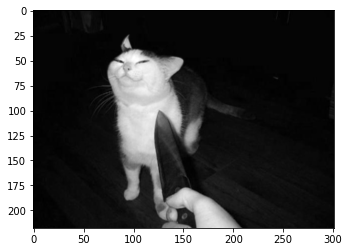

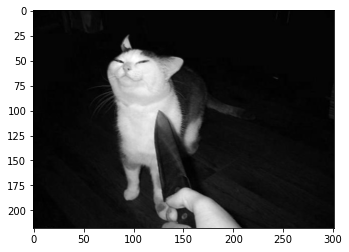

In [9]:
img_out = Conv2DLayer(img, (3,3), 2 , 2, 'meh', 'relu')
print("height * width * depth matched")
plt.imshow(img_out[:,:,0], cmap='gray')
plt.show()
plt.imshow(img_out[:,:,1], cmap='gray')
plt.show()

(146, 201, 3)
height * width * depth matched


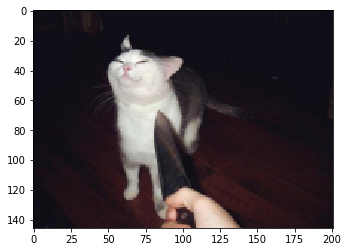

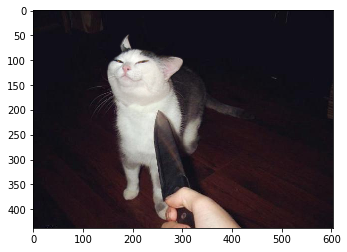

In [10]:
img_out_pool = Pool2DLayer(img, (3,3), 3, 'meh', 'relu', 'avg')
print("height * width * depth matched")
plt.imshow(img_out_pool.astype(int))
plt.show()
plt.imshow(img)
plt.show()

In [11]:
def Unravel(inp, out_size):
    inp = np.ndarray.flatten(inp)
    temp = list(inp.shape)
    temp.append(out_size)
    temp = tuple(temp)
    weight = np.random.uniform(0,1e-2,temp)
    output = np.matmul(inp, weight)
    return output

In [12]:
def Composition(inp, no_hid_layers, conv_pool_order, kernel_list, \
                stride_list, padding_list, activation_list, pool_func_list, \
                no_filters_list, print_arg) :
    x = inp
    for i in range(no_hid_layers):
        if conv_pool_order[i] == 'conv' :
            print("Convolution under process")
            x = Conv2DLayer(x, kernel_list[i], stride_list[i],\
                            no_filters_list[i], padding_list[i], activation_list[i])
            
            if print_arg == 'True':
                plt.imshow(x[:,:,0], cmap='gray')#plotting just the first filter for convinience
                plt.show()
        elif conv_pool_order[i] == 'pool' :
            print("Pooling under process")
            x = Pool2DLayer(x, kernel_list[i], stride_list[i], \
                            padding_list[i], activation_list[i], pool_func_list[i])
            
            if print_arg == 'True':
                plt.imshow(x[:,:,0], cmap='gray')#plotting just the first filter for convinience
                plt.show()
    
    return x

Pooling under process
(146, 201, 3)


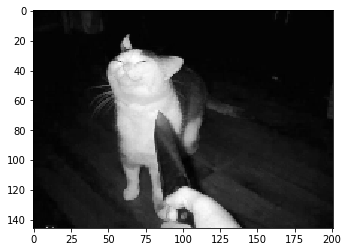

Convolution under process
(72, 100, 3)


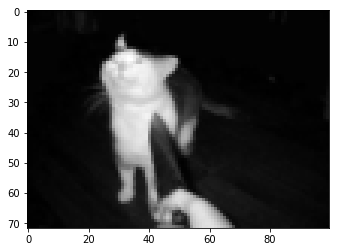

Convolution under process
(35, 49, 1)


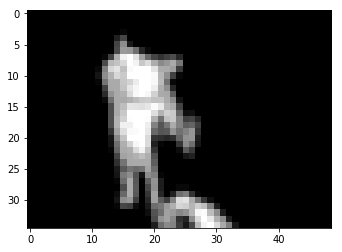

In [13]:
output = Composition(img, 3, ['pool', 'conv', 'conv'], [(3,3), (3,3), (3,3)],\
            [3,3,1], ['meh', 'meh', 'meh'], ['relu', 'relu', 'relu'],\
            ['max','avg','avg'], [2,2,2], 'True')

## MLP implimentation part

Please note that no_of_hidden layers doesn't include input layer.

In [14]:
def FClayer(x,W,b):
    return (np.matmul(W.T,x) + b)

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def FCNet(inp, no_hidden_layers, output_size, no_hidden_nodes, activations):
    x = inp
    Weights_layers = []
    biases_layers = []
    outputs_layers = []
    k = len(x)
    for i in range(no_hidden_layers):
        l = no_hidden_nodes[i]
        size = (k,l)
        W = np.random.uniform(0,1e-3,size)
        b = np.random.uniform(0,1e-3,l)
        Weights_layers.append(W)
        biases_layers.append(b)
        x = FClayer(x,W,b)
        
        if activations[i] == 'sigmoid':
            x = sigmoid(x)
            outputs_layers.append(x)
            
        elif activations[i] == 'tanh' :
            x = tanh(x)
            outputs_layers.append(x)
            
        elif activations[i] == 'relu' :
            x = relu(x)
            outputs_layers.append(x)
        
        k = l
    
    size_new = list(x.shape)
    size_new.append(output_size)
    size_new = tuple(size_new)
    W = np.random.uniform(0,1e-3,size_new)
    b = np.random.uniform(0,1e-3,output_size)
    Weights_layers.append(W)
    biases_layers.append(b)
    x = FClayer(x,W,b)
    outputs_layers.append(x)
    soft_x = softmax(x)
    outputs_layers.append(soft_x)
    
    return Weights_layers, biases_layers, outputs_layers

Testing the MLP function. Just random input output to see if any errors

In [15]:
trash = np.ones(10)
_,_,outs = FCNet(trash, 5, 20, [10,10,10,10,10], activations=['relu','relu','relu','relu','relu'])
print("with softmax :", outs[-1])
print("\n")
print("softmax layer outputs sum :", sum(outs[-1]))
print("\n")
print("without softmax :", outs[-2])

with softmax : [0.04999781 0.04998102 0.04999318 0.05000212 0.04997645 0.05001374
 0.04998607 0.05002095 0.05000702 0.04999415 0.05001732 0.05002172
 0.04999097 0.05001924 0.05000703 0.04998161 0.05002148 0.04997658
 0.05000365 0.0499879 ]


softmax layer outputs sum : 0.9999999999999999


without softmax : [4.91000934e-04 1.55237387e-04 3.98327052e-04 5.77269710e-04
 6.37709699e-05 8.09507771e-04 2.56102638e-04 9.53787098e-04
 6.75258931e-04 4.17873408e-04 8.81080151e-04 9.69144384e-04
 3.54109477e-04 9.19570169e-04 6.75439308e-04 1.66929584e-04
 9.64281555e-04 6.62428048e-05 6.07820287e-04 2.92752795e-04]


## Connecting Conv2DLayer to Unravel and then to MLP

In [16]:
output = Composition(img, 3, ['pool', 'conv', 'conv'], [(3,3), (3,3), (3,3)],\
            [3,3,1], ['meh', 'meh', 'meh'], ['relu', 'relu', 'relu'],\
            ['max','avg','avg'], [2,2,2], 'False')
output = Unravel(output, 512)
_,_,outs = FCNet(output, 3, 3, [512,128,128], activations=['relu','relu','relu'])
print("with softmax :", outs[-1])
print("\n")
print("softmax layer outputs sum :", sum(outs[-1]))
print("\n")
print("without softmax :", outs[-2])

Pooling under process
(146, 201, 3)
Convolution under process
(72, 100, 3)
Convolution under process
(35, 49, 1)
with softmax : [0.33331646 0.33327176 0.33341178]


softmax layer outputs sum : 1.0000000000000002


without softmax : [0.00059212 0.000458   0.00087804]
